# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle

training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
### Replace each question mark with the appropriate value.
import numpy as np

n_train = X_train.shape[0]
n_test = X_test.shape[0]
image_shape = np.asarray(X_train.shape)[1:]
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = [32 32  3]
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

[0, 210, 2430, 4680, 6090, 8070, 9930, 10350, 11790, 13200, 14670, 16680, 18000, 20100, 22260, 23040, 23670, 24090, 25200, 26400, 26610, 26970, 27300, 27690, 28200, 28470, 29970, 30570, 30810, 31350, 31620, 32070, 32850, 33090, 33779, 34199, 35399, 35789, 35999, 38069, 38369, 38729, 38969]


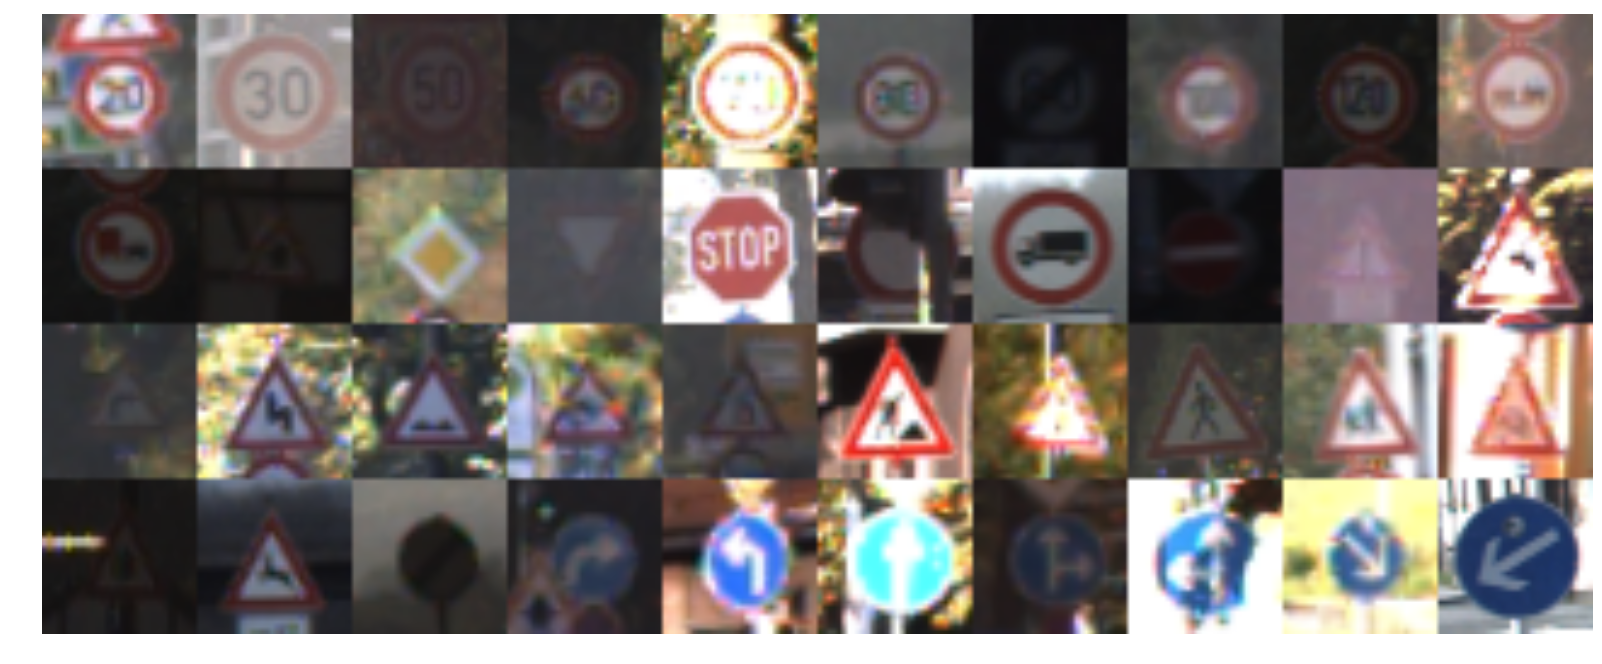

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

# Get one of each of the classes
class_indices = []
for c in range(n_classes):
    gen = (i for i, x in enumerate(y_train) if x == c)
    idx = next(gen)
    class_indices.append(idx)

sample_images = X_train[class_indices]
print(class_indices)

def plot_image_grid(imgs, row_size=10, figsize=None, cmap=None):
    """plots a grid of images"""
    if figsize is None:
        figsize = (20,20)
    n_imgs = len(imgs)
    idx=0
    rows = []
    while(idx < n_imgs and n_imgs - idx > row_size - 1):
        rows.append(np.concatenate(imgs[idx:idx+row_size], axis=1))
        idx += row_size
    if len(rows) > 1:
        plot_img = np.concatenate(rows, axis=0)
    else: 
        plot_img = rows[0]
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(plot_img, cmap=cmap)
    
plot_image_grid(sample_images)

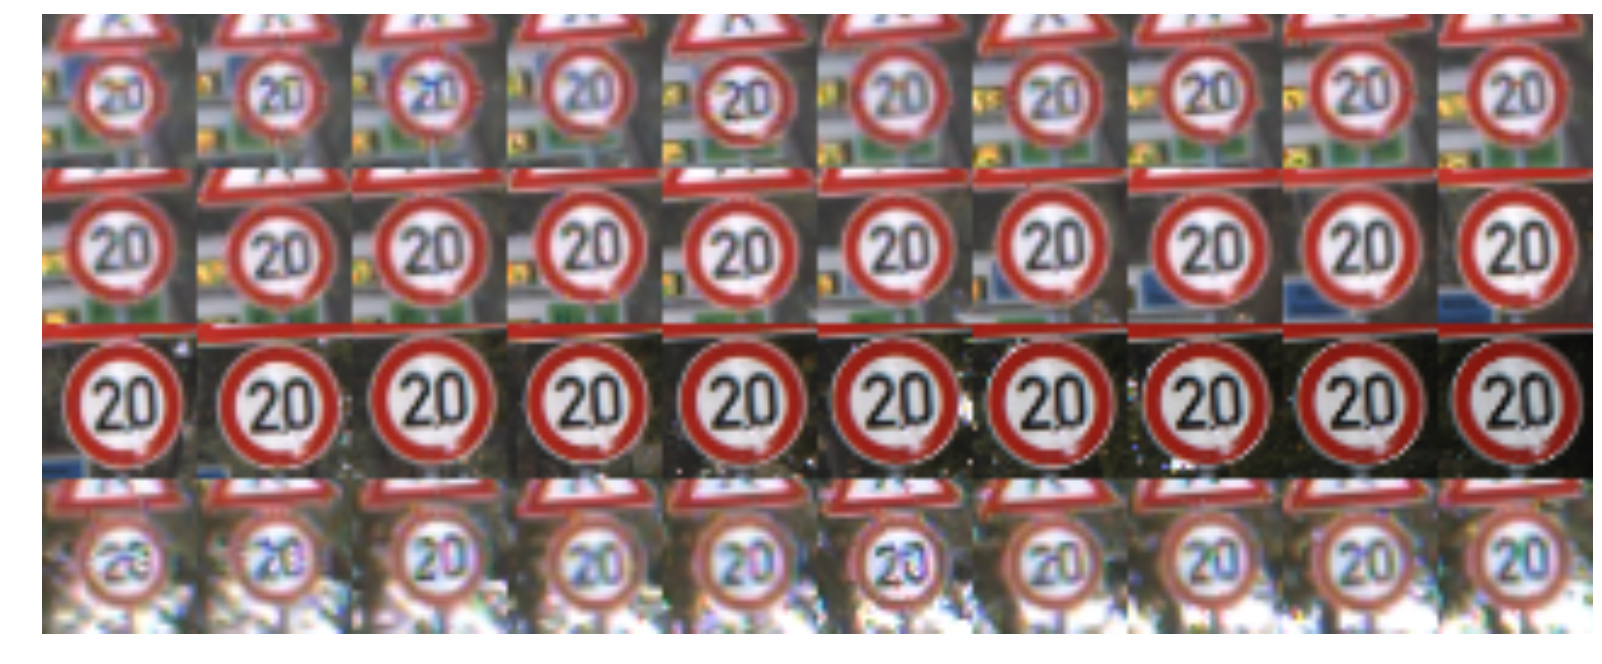

In [5]:
plot_image_grid(X_train[0:40])

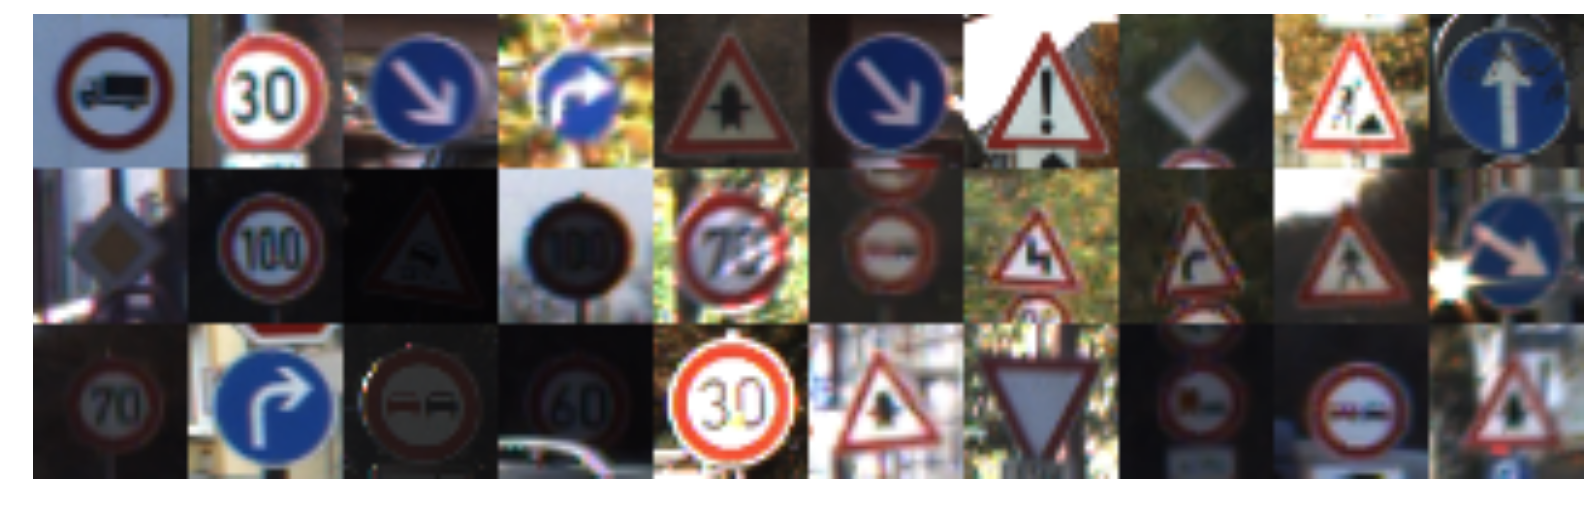

In [6]:
plot_image_grid(X_test[0:30])

<Container object of 43 artists>

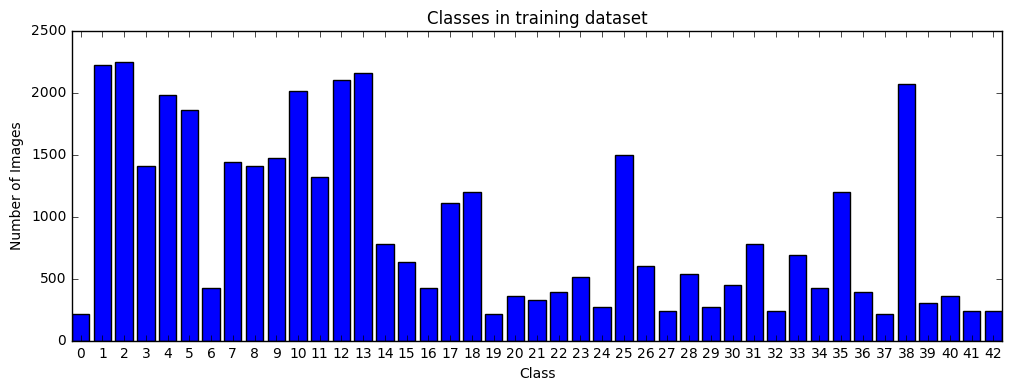

In [22]:
# Plot a histogram of all the labels
bins = np.bincount(y_train)
plt.figure(figsize=(12,4))
plt.title("Classes in training dataset")
plt.xlabel("Class")
plt.xticks(np.arange(n_classes))
plt.ylabel("Number of Images")
plt.bar(np.arange(n_classes), bins, align='center')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [6]:
### Preprocess Data

# First, split the data into train, validation and test sets
validation_indices = np.concatenate([np.arange(i, i + 30) for i in class_indices])
X_validation = X_train[validation_indices]
y_validation = y_train[validation_indices]

# Remove validation set from training set
mask = np.ones(n_train).astype(np.bool)
mask[validation_indices] = False
X_train = X_train[mask]
y_train = y_train[mask]

# recalculate dataset lengths
n_train = X_train.shape[0]
n_validation = X_validation.shape[0]

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)


Number of training examples = 37919
Number of validation examples = 1290
Number of testing examples = 12630


In [7]:
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank

def preprocess_image_data(X_data):
    """Preprocess image data for use in CNN"""
    # Convert to grayscale
    rgb2gray = np.array([[0.299, 0.587, 0.114]])
    X_data = np.dot(X_data, rgb2gray.T).astype(np.uint8)

    # Perform global and local contrast normalization
    X_global_eq = exposure.equalize_hist(X_data)
    X_local_eq = [rank.equalize(x.reshape(32, 32), selem=disk(6)) for x in X_global_eq]
    X_local_eq = np.asarray(X_local_eq).reshape(-1, 32, 32, 1)

    # Normalize to 0-1.0 floats
    X_data = X_local_eq / 255.0

    return X_data

# Preprocess training, validation and test data
X_train = preprocess_image_data(X_train)
X_validation = preprocess_image_data(X_validation)
X_test = preprocess_image_data(X_test)


C:\Users\jusku\Anaconda3\envs\udacity\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [8]:
### Generate Additional Data
from scipy.ndimage.interpolation import rotate, shift

def jitter_image(img):
    """Jitters an image by shifting and rotating the image randomly"""
    img = rotate(img, np.random.randint(-4, 5, 1), reshape=False, mode='reflect')
    x, y = np.random.randint(-2, 3, 2)
    img = shift(img, (x, y, 0) , mode='reflect')
    return img


def generate_image_data(X_data):
    """Generates new image data by jittering each image in X_data"""
    x_new = [jitter_image(x) for x in X_data]
    return np.asarray(x_new)

# Generate an additional three 'jittered' sets of data
X_train = np.concatenate([X_train, 
                          generate_image_data(X_train), 
                          generate_image_data(X_train), 
                          generate_image_data(X_train)])
y_train = np.tile(y_train, 4)

n_train = X_train.shape[0]
print("Number of training examples =", n_train)

Number of training examples = 151676


In [9]:
from sklearn.utils import shuffle

# Shuffle the training data
X_train, y_train = shuffle(X_train, y_train, random_state=0)

# One hot encode the labels so we can use softmax
def one_hot(indices, depth):
    """Convert 1-D data labels to 2-D one hot encoding"""
    onehot = np.zeros((len(indices), depth))
    onehot[np.arange(len(indices)), indices] = 1
    return onehot

y_train_one_hot = one_hot(y_train, n_classes)
y_validation_one_hot = one_hot(y_validation, n_classes)
y_test_one_hot = one_hot(y_test, n_classes)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

First I converted all the images to grayscale.  I also experimented with using a [YUV color space](https://en.wikipedia.org/wiki/YUV) but found that grayscale preformed slight better.  This is likely due to the fact that most of traffic signs in this dataset are the same color (red or blue) and therefore color alone is a poor predictor of class.  By stripping out color the CNN is forced to instead develop features based on the geometry.

Second I preformed both a [global histogram equalization](https://en.wikipedia.org/wiki/Histogram_equalization) to correct for differing contrasts due to lighting conditions.  Then I preformed a [local histogram equalization](http://scikit-image.org/docs/dev/auto_examples/plot_local_equalize.html) to further accent the edges and curves of the signs.

Finally I normalized the pixel values to be between zero and one.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

The training set provided is made up of a series of 30 images of each individual traffic sign as the camera approaches.  Since most of the images are duplicates, picking a validation set in a purely random manner would be a poor indicator of accuracy since it would be validating on data that the model had trained on.  Therefore I choose to pick (as cued to in the above mentioned paper) a set of 30 images from each of the 43 class.   The result is a validation set of 1290.


I generated additional data by 'jittering' the training.  I first shifted the image by randomly by up to 2 pixels in the both the x an y direactions and then randomly rotated it by a few degrees.  I did this three times over the initial training to get a total of 151676 training images.

In [10]:
### Define the network archiecture

import tensorflow as tf

# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    """Conv2D wrapper, with bias and relu activation"""
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    """MaxPool2D wrapper"""
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

def traffic_net(x, weights, biases, dropout):
    """CNN architiecture for detecting traffic signs"""
    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    conv1 = conv2d(conv1, weights['wc2'], biases['bc2'])
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc3'], biases['bc3'])
    conv2 = conv2d(conv2, weights['wc4'], biases['bc4'])
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    fc2 = tf.nn.relu(fc2)
    
    # Apply Dropout
    fc2 = tf.nn.dropout(fc2, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])

    return out


# Store layers weight & bias
weights = {
    # ConvNet layers
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 50])),
    'wc2': tf.Variable(tf.random_normal([5, 5, 50, 50])),
    'wc3': tf.Variable(tf.random_normal([5, 5, 50, 100])),
    'wc4': tf.Variable(tf.random_normal([5, 5, 100, 100])),
    # fully connected,84*8*100 inputs, 3036 outputs
    'wd1': tf.Variable(tf.random_normal([8*8*100, 3036])),
    'wd2': tf.Variable(tf.random_normal([3036, 3036])),
    # 3036 inputs, 43 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([3036, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([50])),
    'bc2': tf.Variable(tf.random_normal([50])),
    'bc3': tf.Variable(tf.random_normal([100])),
    'bc4': tf.Variable(tf.random_normal([100])),
    'bd1': tf.Variable(tf.random_normal([3036])),
    'bd2': tf.Variable(tf.random_normal([3036])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

I choose an architecture that has two layers, each with two convolutions  followed by a max pool with depths of 50 and 100 respectively.  Each maxpool has kernal size of 2x2 with a stride of 2x2 to reduce the map size by 75%.  I then have two fully connected layers with 3000 nuerons each that feed into the logits.  I add a dropout layer before the logits for robustness.

```
INPUT: [32x32x1]
CONV2D-50: [32x32x50]
CONV2D-50: [32x32x50]
POOL2: [16x16x50]
CONV2D-100: [32x32x100]
CONV2D-100: [32x32x100]
POOL2: [8x8x100]
FC: [1x1x3000]
FC: [1x1x3000]
FC: [1x1x43]
```


In [11]:
### Setup the tensorflow graph

# Hyper-parameters
LEARNING_RATE = 0.0025
DISPLAY_STEP = 100
EPOCHS = 6
BATCH_SIZE = 128
DROPOUT = 0.75

# tf graph input
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None, n_classes))

keep_prob = tf.placeholder(tf.float32)  # dropout (keep probability)

# Construct model
pred = traffic_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()
#init = tf.initialize_all_variables()

# Define a function to evaluate a dataset
def eval_dataset(X_data, y_data):
    """Evaluate the loss and accuracy on a dataset"""
    n_data = X_data.shape[0]
    steps_per_epoch = n_data // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE
    total_acc, total_loss = 0, 0
    for step in range(steps_per_epoch):
        idx_start = (step * BATCH_SIZE) % n_train
        idx_end = idx_start + BATCH_SIZE
        batch_x = X_data[idx_start:idx_end]
        batch_y = y_data[idx_start:idx_end]
        loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.})
        total_acc += (acc * batch_x.shape[0])
        total_loss += (loss * batch_x.shape[0])
    return total_loss / num_examples, total_acc / num_examples

In [12]:
### Train the model

sess = tf.Session()
sess.run(init)
steps_per_epoch = n_train // BATCH_SIZE
step = 0
for i in range(EPOCHS):
    for step in range(steps_per_epoch):
        idx_start = (step * BATCH_SIZE) % n_train
        idx_end = idx_start + BATCH_SIZE
        batch_x = X_train[idx_start:idx_end]
        batch_y = y_train_one_hot[idx_start:idx_end]
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: DROPOUT})
        if step % DISPLAY_STEP == 0:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x, y: batch_y, keep_prob: DROPOUT})
            print("Iter " + str(step * BATCH_SIZE) + ", Minibatch Loss= " +
                  "{:.6f}".format(loss) + ", Training Accuracy= " +
                  "{:.5f}".format(acc))   
    val_loss, val_accuracy = eval_dataset(X_validation, y_validation_one_hot)
    print("EPOCH {}...\n".format(i + 1) +
          "Validation Loss= " + "{:.6f}, ".format(val_loss) + 
          "Validation Accuracy= " + "{:.6f}".format(val_accuracy))
    
    test_loss, test_accuracy = eval_dataset(X_test, y_test_one_hot)
    print("Testing Loss= " + "{:.6f}, ".format(test_loss) +
          "Testing Accuracy= " + "{:.6f}".format(test_accuracy))

print("Optimization Finished!")

Iter 0, Minibatch Loss= 317373568.000000, Training Accuracy= 0.01562
Iter 12800, Minibatch Loss= 5841283.000000, Training Accuracy= 0.35156
Iter 25600, Minibatch Loss= 3137101.000000, Training Accuracy= 0.42188
Iter 38400, Minibatch Loss= 1866776.500000, Training Accuracy= 0.54688
Iter 51200, Minibatch Loss= 1474030.750000, Training Accuracy= 0.53125
Iter 64000, Minibatch Loss= 778343.375000, Training Accuracy= 0.68750
Iter 76800, Minibatch Loss= 550746.125000, Training Accuracy= 0.69531
Iter 89600, Minibatch Loss= 476826.906250, Training Accuracy= 0.75781
Iter 102400, Minibatch Loss= 505371.406250, Training Accuracy= 0.68750
Iter 115200, Minibatch Loss= 457469.937500, Training Accuracy= 0.75000
Iter 128000, Minibatch Loss= 305627.437500, Training Accuracy= 0.81250
Iter 140800, Minibatch Loss= 443300.218750, Training Accuracy= 0.77344
EPOCH 1...
Validation Loss= 657108.740625, Validation Accuracy= 0.672656
Testing Loss= 287652.312978, Testing Accuracy= 0.813297
Iter 0, Minibatch Loss= 

In [13]:
# Evaluate the final model on the test dataset
test_loss, test_accuracy = eval_dataset(X_test, y_test_one_hot)
print("Testing Loss= " + "{:.6f}, ".format(test_loss) +
      "Testing Accuracy= " + "{:.6f}".format(test_accuracy))

Testing Loss= 98772.978825, Testing Accuracy= 0.927216


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

When training the model, I used tensorflow's implementation of an [ADAM optimizer](https://arxiv.org/pdf/1412.6980v8.pdf).  The main benifit with ADAM over a simple gradient descent algorithm is that it uses a moving average of all parameters (momentum) to scale the effective step size which means less tuning of the initial learning rate is needed.

The model is trained in batches and repeated for a number of epochs.  The number of epochs needed was determined experimentally.  I stop training the model right before the validation accuracy begins to decrease due to overfitting.

I found that one of the most influential hyper-parameters was the learning rate.   Increasing the number of free parameters in the model required decreasing the learning rate to preform well.  A learning rate that was too high would fail to converge.


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

Most of the architectures I tried were based on the following pattern described [here](http://cs231n.github.io/convolutional-networks/#architectures)  

```
INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC
```

In particular, I drew inspiration from the image classifer [VGGNet](https://arxiv.org/pdf/1409.1556.pdf).  VGGNet has a five layers consisting of 2-3 convultions followed a maxpool.  

Since the number of classes and image resolution used in this project was much smaller than VGGNet, I scaled down the of number of feature maps and convultions. I choose an architecture that has two layers, each with two convolutions followed by a max pool and depths of 50 and 100 respectively.  Each maxpool has kernal size of 2x2 with a stride of 2x2 to reduce the map size by 75%.  I then have two fully connected layers with 3036 nuerons each that feed into the logits.  

The most influential hyper-parameters was the learning rate.  Too high a value would overshoot and fail to increase accuracy, too low and training took a very long time.  I found experimentally that a learning rate  0.0025 preformed well.  I bounded the number of epochs (iterations over the entire training set) to 6.  Too many iterations of training and the model would overfit and begin to lose validation accurracy.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

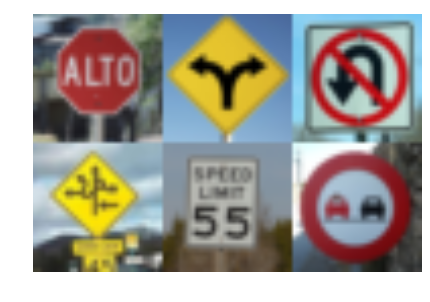

In [14]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
from scipy.misc import imread, imresize
filenames = [
    'signs/sign1.png', 
    'signs/sign2.png', 
    'signs/sign3.png', 
    'signs/sign4.png', 
    'signs/sign5.png', 
    'signs/sign6.png',
]
imgs = np.asarray([imresize(imread(f), (32,32)) for f in filenames])
plot_image_grid(imgs, row_size=3, figsize=(5,5))

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

I choose the six signs pretty randomly from a few google searches.  I expect that the stop sign and the no passing sign will be the easiest for the CNN model to classify.  The remaing signs will likely be hard to classify since they are not well represented in the available classes or training data.  For example the speed limit sign is rectangular while all the speed limit signs in the training dataset are round.


C:\Users\jusku\Anaconda3\envs\udacity\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


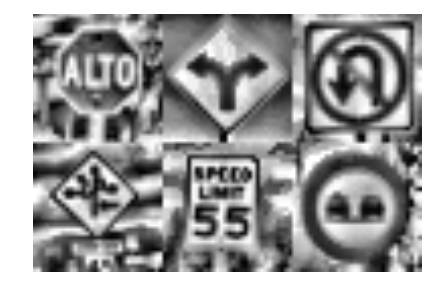

In [15]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

# preprocess the new images and plot the results
processed_imgs = preprocess_image_data(imgs)
plot_image_grid(processed_imgs.reshape((-1, 32,32)), row_size=3, figsize=(5,5), cmap='gray')

In [16]:
# run the processed images through the predictor
softmax_pred = sess.run(tf.nn.softmax(pred), feed_dict={x: processed_imgs, keep_prob: 1.0})

In [17]:
predictions = np.argmax(softmax_pred, axis=1)
print(predictions)

[14 13 40 12 11  9]


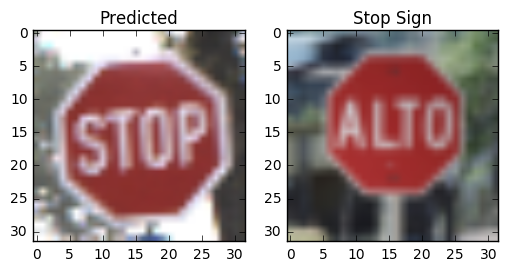

In [18]:
idx = 0  
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.set_title("Predicted")
ax1.imshow(train['features'][class_indices[predictions[idx]] + 23])
ax2.set_title("Stop Sign")
ax2.imshow(imgs[idx])

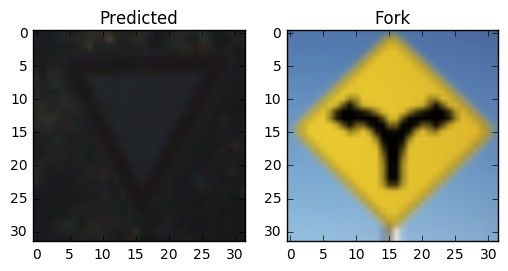

In [19]:
idx = 1 
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.set_title("Predicted")
ax1.imshow(train['features'][class_indices[predictions[idx]] + 23])
ax2.set_title("Fork")
ax2.imshow(imgs[idx])

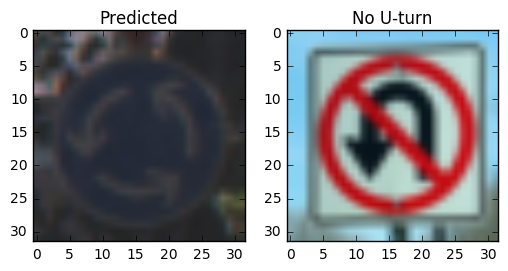

In [20]:
idx = 2
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.set_title("Predicted")
ax1.imshow(train['features'][class_indices[predictions[idx]] + 23])
ax2.set_title("No U-turn")
ax2.imshow(imgs[idx])

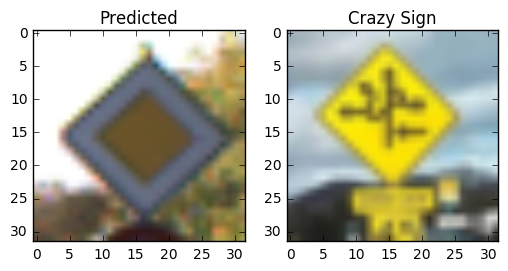

In [21]:
idx = 3
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.set_title("Predicted")
ax1.imshow(train['features'][class_indices[predictions[idx]] + 23])
ax2.set_title("Crazy Sign")
ax2.imshow(imgs[idx])

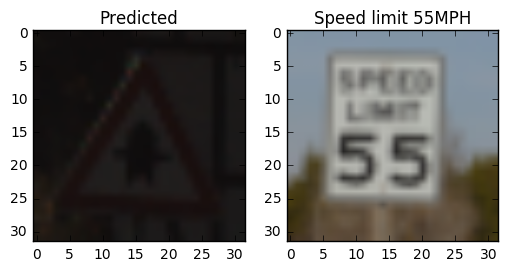

In [22]:
idx = 4  
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.set_title("Predicted")
ax1.imshow(train['features'][class_indices[predictions[idx]] + 23])
ax2.set_title("Speed limit 55MPH")
ax2.imshow(imgs[idx])

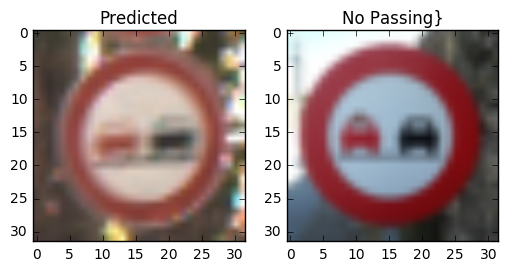

In [23]:
idx = 5
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.set_title("Predicted")
ax1.imshow(train['features'][class_indices[predictions[idx]] + 23])
ax2.set_title("No Passing}")
ax2.imshow(imgs[idx])

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

The model predicted the test dataset with 92.7% accuracy.  Here the model predicted the new *'No Passing'* and *'Stop'* signs with 100% accuray.  The rest of the new images don't fall into an easy category so it's not possible to assign a exact accuracy, but visually we can see it does a good job finding a close approximation.  From this we can surmise that our model does preform roughly as well on the new signs.

The above plots show a side-by-side graph of the input image and a image from the predicted class so we can draw comparisons.  It is able to correctly classify the *'No-Passing'* sign as well as the *'Stop'* sign even though the *'Stop'* sign is in a different langauge.

The rest of the signs do not fall into any of the existing classes, but are mostly matched with signs that are visually similar.  The two yellow diamond signs are matched with the *'Priority road'* sign that is also a diamond shape.  The *'No U-turn'* sign is matched with the *'Round-About'* sign that also has a large circular shape in the middle.  

The only sign that was complete unrecognizable was the speed limit sign, which was predicted to be a *'Right-of-way'* sign.  This was expecteded since, as noted above, it was a rectangular sign whereas all the signs in the training set where either round, triangle, or diamond shaped.


In [24]:
### Print out the softmax predictions
print(softmax_pred)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  

<Container object of 43 artists>

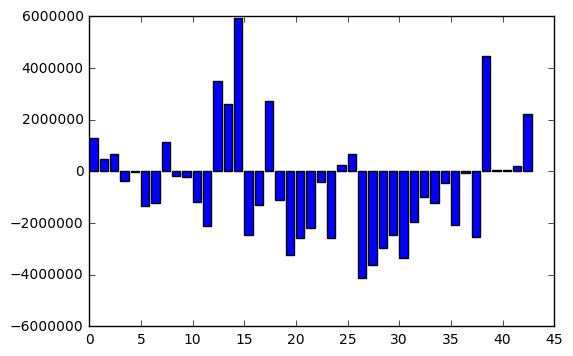

In [25]:
### Get the raw predictions (the input into the softmax) and plot a few

raw_pred, topk_pred = sess.run([pred, tf.nn.top_k(pred)], feed_dict={x: processed_imgs, keep_prob: 1.0})
plt.bar(np.arange(43), raw_pred[0])

<Container object of 43 artists>

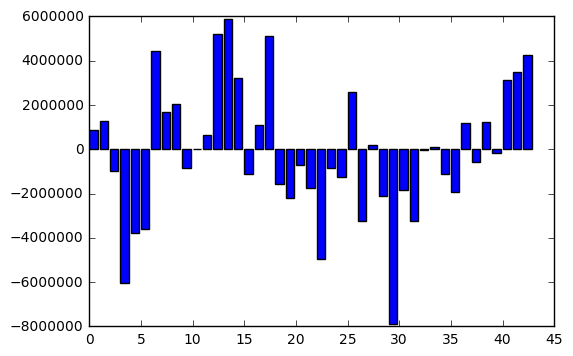

In [26]:
plt.bar(np.arange(43), raw_pred[1])

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

The actual softmax probabilities were actually very uninteresting. Every probability ended up being zero except the predicted class, indicating the model was extermely certain of its prediction.

Looking at the raw prediction values that are fed into the softmax function reveal the reason: Many of the predictions are negative and their value are huge ranging from plus or minus 1e7. Since the softmax function uses the sum of all the inputs in the exponent of it's divisor, it forces all of the outputs to go to zero.
```
softmax = exp(logits) / reduce_sum(exp(logits))
```

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.